X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


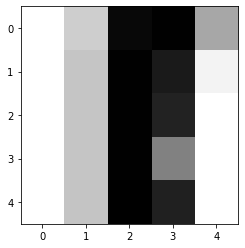

And the whole sample:


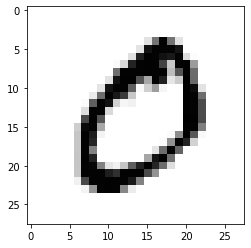

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]
(50000,)


In [15]:
from matplotlib import pyplot as plt
from data import load_dataset_from_file
from data_visulisation import *
from util import *
import numpy as np
import tqdm
import time
from IPython.display import clear_output
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset_from_file()
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])
X_train,Y_train,X_test,Y_test=dataset()
Y_train=Y_train.reshape((1,-1))
Y_test=Y_test.reshape((1,-1))

In [16]:
def initialize_layer(dims): ###initialize the weight and bias matrix of every layer 
    np.random.seed(3)
    parameters={}
    L=len(dims)
    for i in range(1,L):
        parameters['W'+str(i)]=np.random.randn(dims[i],dims[i-1])*np.sqrt(2/dims[i-1])
        # print("--", parameters['W'+str(i)].shape)
        parameters['b'+str(i)]=np.zeros((dims[i],1))
    return parameters


In [17]:
def linear_forward(A,W,b): ##calculate the z
    z=np.dot(W,A)+b
    cache=(A,W,b)
    return z,cache

In [18]:
def linear_forward_pass(A_prev,W,b,activation): ## calculate activation of layer
    if activation=="sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
    elif activation=="Relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)
    return A,cache

In [19]:
def L_layer_forward_pass(X,parameters):
    caches=[]
    A=X
    L=len(parameters)//2
    for l in range(1,L):
        A_prev=A
        A,cache=linear_forward_pass(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"Relu")
        # print("caches for ",l,"layers ",cache)
        caches.append(cache)
    AL,cache=linear_forward_pass(A,parameters['W'+str(L)],parameters['b'+str(L)],"Relu")
    # print("caches for ",L,"layers ",cache)
    caches.append(cache)
    return AL,caches

In [20]:
def linear_backward(dZ,cache):
    A_prev, W, b = cache
    # print(A_prev.shape,dZ.shape)
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*(np.sum(dZ,axis=1,keepdims=True))
    dA_prev = np.dot(W.T,dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

In [21]:
def linear_activation_backward(dA, cache, activation):
    linear_cache,activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, cache[0])
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, cache[0])
    
    return dA_prev, dW, db

In [22]:
def L_model_backward(AL, Y, caches):
   
    grads = {}
    L = len(caches) 
    dAL = softmax_grad(AL,Y)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,"relu")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)], current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [23]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] =parameters["W" + str(l+1)]-learning_rate*grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] =parameters["b" + str(l+1)]-learning_rate*grads["db"+str(l+1)]
    return parameters

In [24]:
def Accuracy(X,Y,parameters):
    AL,caches=L_layer_forward_pass(X,parameters)
    
    p=np.argmax(AL,axis=0)
    #print(AL[:,[0,1,2,3,4,5,6]])
    #print(AL.shape,p.shape,Y.shape)
    #print(p[0:10],Y[0:10])
    return str(np.mean(p == Y))

In [25]:
def predict(X_input,parameters):
    AL,caches=L_layer_forward_pass(X_input,parameters)
    p=np.argmax(AL,axis=0)
    return p

In [26]:
def iterate_minibatches(inputs, targets, batchsize):
    for start_idx in tqdm.tqdm(range(0, inputs.shape[1] - batchsize + 1, batchsize)):
        yield inputs[:,start_idx:start_idx+batchsize], targets[:,start_idx:start_idx+batchsize]

In [27]:
def train(X_train,Y_train,learning_rate,dims,X_test,Y_test):
    parameters=initialize_layer(dims)
    AL,caches=L_layer_forward_pass(X_train,parameters)
    p=np.argmax(AL,axis=0)
    #print(AL[:,[0,1,2,3,4,5,6]])
    #print(AL.shape,p.shape,Y.shape)
    #print(p[0:10],Y[0:10])
    # print(Y_train.shape)
    # print(p[0:100],Y_train[0,0:100])
    train_log=[]
    val_log=[]
    for epoch in range(20):

        for x_batch,y_batch in iterate_minibatches(X_train,Y_train,batchsize=32):
            AL,caches=L_layer_forward_pass(x_batch,parameters)
            loss=softmax_loss(AL,y_batch)
            grads=L_model_backward(AL, y_batch, caches)
            parameters=update_parameters(parameters, grads, learning_rate)
        train_log.append(Accuracy(X_train,Y_train,parameters))
        val_log.append(Accuracy(X_test,Y_test,parameters))
        
        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        plt.plot(train_log,label='train accuracy')
        plt.plot(val_log,label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    # AL,caches=L_layer_forward_pass(X_train,parameters)
    
    # p=np.argmax(AL,axis=0)
    #print(AL[:,[0,1,2,3,4,5,6]])
    #print(AL.shape,p.shape,Y.shape)
    #print(p[0:10],Y[0:10])
    # print(Y_train.shape)
    # print(p[0:100],Y_train[0,0:100])    

Epoch 19
Train accuracy: 0.99976
Val accuracy: 0.9801


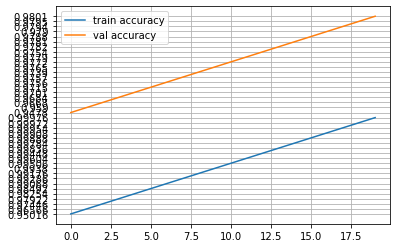

Time take is :-  77.29482674598694  Seconds
[784, 128, 64, 10]


In [28]:
dims=[]
print("Enter the dimesion of the layers")
r=list(map(int,input().split()))
dims.append(X_train.shape[0])
for i in r:
    dims.append(int(i))
dims.append(10)
start_time=time.time()
train(X_train,Y_train,0.1,dims,X_test,Y_test)
print("Time take is :- ",time.time()-start_time," Seconds")
print(dims) 